# Figure 1: Example sentence illustrating measures used in GLM analysis
This notebook contains all code used to set up figure 1, which illustrates the measures used in GLM analysis.

# TODO
- edit hard

#### Measures of interest:
<ul>
    <li>next-word entropy</li>
    <li>surprisal</li>
</ul>

#### Measures of no interest:
<ul>
    <li>word frequency</li>
    <li>instantaneous visual change (IVC), contolling for actor movement</li>
    <li>audio envelope, controlling for low-level auditory effects</li>
</ul>


## Importing Modules and Datasets
Several dataframes will need to be set up.
<ul>
    <li>d will be the complete word dataset</li>
    <li>s will contain only word data for our sequence of interest</li>
    <li>a will contain relevant data for the audio envelope</li>
    <li>m will contain relevant data for the IVC (movement) envelope</li>
</ul>

In [1]:
# imports
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import cv2 #computer vision
import os #directories
import matplotlib.image as mpimg #matplotlib for images
import math
import matplotlib.patches as mpatches #matplotlib for legend 
import matplotlib.gridspec as gridspec #advanced subplots

In [ ]:
workingDirectory = os.getcwd()

Here, the dataset containing a part of the story is loaded into a variable d as a pandas dataframe. Each word has been included as a row with each column representing another measure. It is subsequently subsampled to include only the content words of the storylet (isC) and then further split into two smaller dataframes only containing a subset of content words that have been coded as either a "key" (K) or "nonkey" (NK) words. In this nomenclaure, all "key" words are accompanied by a gesture and all "nonkey" words are not. These three subsampled dataframes will later be used to construct histograms conveying the distribution of entropy and surprisal across these conditions.

Additionally, the data containing IVC and audio envelopes, form which confound regressors were calculated are loaded here.

In [54]:
os.chdir(workingDirectory)

# loading data
d = pd.read_csv('data/samirdata_XF_1.csv')

# loading ivc and auditoy envelopes, make sure to choose the appropriate storylet 01-16
ivc_env = pd.read_csv('data/04_Samir_blieb_IVC.csv')
aud_env = pd.read_csv('data/04_audio_envelope.csv')

# sub-dataframes for histograms
isC = d.loc[d.isC == 1].reset_index()[['word', 'Entropy_Roark', 'Surprisal_Roark','is_key', 'isC', 'is_key_and_C']]
isC_K = d.loc[d.is_key_and_C == 1].reset_index()[['word', 'Entropy_Roark', 'Surprisal_Roark','is_key', 'isC', 'is_key_and_C']]
isC_NK = d.loc[(d.isC == 1) & (d.is_key != 1)].reset_index()[['word', 'Entropy_Roark', 'Surprisal_Roark','is_key', 'isC', 'is_key_and_C']]

# extracting columnns of interest from d
d = d[['word', 'freq', 'ivc_avg', 'Entropy_Roark', 'Surprisal_Roark',
       'env_avg','is_key','xmax', 'xmin', 'entropy']]

# adding average time column per word to d
d['xavg'] = (d['xmax']+d['xmin'])/2

Now, the sequence of words that will later be displayed in the figure is chosen by indexing d. This can be any sequence of words from the storylet. Using the time information of the chosen sentences, the corresponding data of ICV and audio envelopes is selected into vartiables m and a.


In [60]:
# set s, can be any sequence of words from the desired storylet
s = d.iloc[614:624].reset_index()
s['freq'] = s['freq'].replace([0.0],0.2)

# new timing columns starting at 0
s['xavg0'] = s['xavg'] - s['xmin'].min() 
s['xmin0'] = s['xmin'] - s['xmin'].min() 
s['xmax0'] = s['xmax'] - s['xmin'].min()

# getting ivc up to some index according to our desired sentence
m = ivc_env.loc[s['xmin'].min() * 100 : s['xmax'].max()*100].reset_index()
m['time'] = m['time'] - s['xmin'].min() #correcting time to start at 0

# rolling average for smoother curve
window_size = 5
m['rolling_avg'] = m['ivc_standarized'].rolling(window_size).mean()
# replacing window-size nans at start
m['rolling_avg'] =  m['ivc_standarized'][:window_size-1].append( m['rolling_avg'][window_size-1:])

# getting audio env up to some index according to our desired sentence
a = aud_env.loc[s['xmin'].min() * 100 : s['xmax'].max()*100].reset_index()
a['time'] = a['time'] - s['xmin'].min() #correcting time to start at 0

# rolling average for smoother curve
a['rolling_avg'] = a['envelope_standardized'].rolling(window_size).mean()
# replacing window-size nans at start
a['rolling_avg'] =  a['envelope_standardized'][:window_size-1].append( a['rolling_avg'][window_size-1:])

## Extracting and Cropping Frames of interest

For displaying the stimuli shown in the scanner alongside the chosen sentence and regressors, the python library OpenCV is used to extract and save equidistant frames from the video pertaining to the selected sentence.

In [ ]:
# cropping parameters
y = 75 
x = 260 
h = 500 
w = 230

# even spacing of frames in time
n = 13 # number of frames
frametimes = np.arange(s.xmin.min(), s.xmax.max(), s.xmax0.max()/n) * 1000

# set output directory
outputDirectory = workingDirectory + '/framesCropped'

# initialize capture object with cv2
# make sure to include the appropriate file 01-16
cap = cv2.VideoCapture('data/04_Samir_blieb.mpeg')

# initialize output directory, if not already existing
if not os.path.exists(outputDirectory):
    os.mkdir(outputDirectory)

os.chdir(outputDirectory)

# clear output directory
for f in os.listdir(outputDirectory):
    os.remove(os.path.join(outputDirectory, f))

# get, crop and save frames
for i in range(len(frametimes)):
    cap.set(0, frametimes[i]) # set msec of video here
    ret, frame = cap.read() # get frame
    crop_img = frame[y:y+h, x:x+w] # crop frame
    if i < 10:    
        cv2.imwrite('frame0'+str(i)+'.jpeg', crop_img) # save frame
    else:
        cv2.imwrite('frame'+str(i)+'.jpeg', crop_img) # save frame

os.chdir(workingDirectory)

Here, the cropped frames are loaded, appended together and plotted.

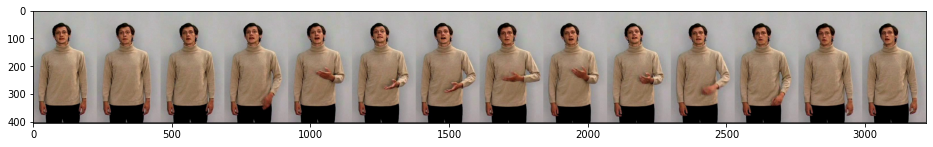

In [51]:
# loading and appending frames
#outputDirectory = workingDirectory + '/framesCropped'
os.chdir(outputDirectory)

framelist = [f for f in os.listdir(outputDirectory)] # get frames from outputdir
frames = [mpimg.imread(frame) for frame in framelist] # load all frames 

os.chdir(workingDirectory)

# append frames, this might be done more elegantly
longframe = frames[0]
for frame in frames[1:]:
    longframe = np.append(longframe,frame, axis = 1)

# plotting frames  
fig, ax = plt.subplots(1,1, figsize = (16,5))
plt.imshow(longframe)

## Plotting

Now, everything is ready to be put together into one figure with the example sentence in the middle and several subplots (axes) around it, visualizing the different regressors, accompanying video and distribution of entropy and surprisal values across key- and nonkey-words.

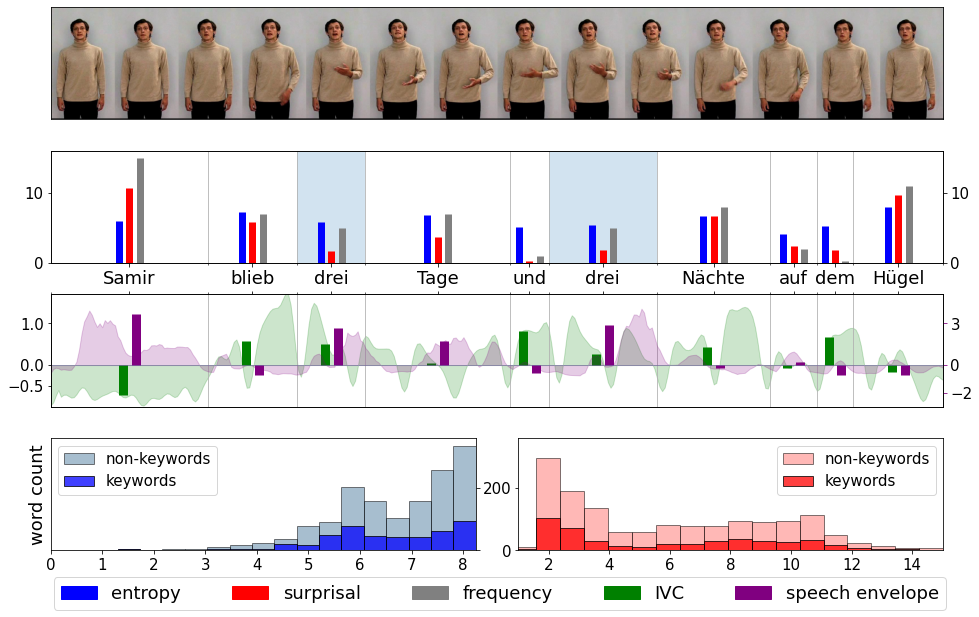

In [61]:
# setting up subplot structures
fig = plt.figure(figsize = (16,10))

# gridspec tool
gs = fig.add_gridspec(4, 2, hspace = 0.28, wspace = 0.1)

# 5 axes
ax1 = fig.add_subplot(gs[0, :]) # frames
ax2 = fig.add_subplot(gs[1, :]) # word-wise entropy, surprisal, frequency
ax3 = fig.add_subplot(gs[2, :]) # ivc and audio envelopes
ax4 = fig.add_subplot(gs[3, 0]) # entropy distribution histogram
ax5 = fig.add_subplot(gs[3, 1]) # surprisal distribution histogram

# plotting the frames
ax1.imshow(longframe)

# remove ticks for ax1
ax1.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax1.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)

w1 = 7 # linewidth for entropy, surprisal, frequency
w2 = 9 # linewidth for ivc, audio

# positions for lines relative to word averages
# entropy, surprisal, frequency
left = s['xavg0'] - 0.025
right = s['xavg0'] + 0.025
middle = s['xavg0']

# ivc, audio
left2 =  s['xavg0'] - 0.04
right2 =  s['xavg0'] + 0.04
middle2 =  s['xavg0']

# plotting lineplots for entropy and surprisal
ax2.vlines(left2, [0], s.iloc[:,4], color = "blue", linewidth=w1) #entropy
ax2.vlines(middle2, [0], s.iloc[:,5], color = "red", linewidth=w1) #surprisal

# setting up twin axis for frequency
axfreq = ax2.twinx()
axfreq.vlines(right2, [0], s.iloc[:,2], color = "grey", linewidth=w1) # frequency

# ax2 cosmetics
ax2.set_xticks(s['xavg0'], minor = False )
ax2.set_xticks(s['xmax0'], minor = True) # onsets/offsets of words
ax2.xaxis.grid(True, which='minor')
ax2.set_xticklabels(s['word'], fontsize = 18)
ax2.tick_params(axis='y', labelsize = 15)
ax2.set_ylim(0, 16)
ax2.axis(xmin= s['xmin0'].min(), xmax= s['xmax0'].max())
axfreq.tick_params(axis='y', labelsize = 15)
axfreq.set_ylim(0, 16)

# plotting lineplots for ivc and audio
ax3.vlines(left, [0], s.iloc[:,3], color = "green", linewidth=w2) # ivc
ax3.vlines(right, [0], s.iloc[:,6], color = "purple", linewidth=w2) # aud

# ax3 cosmetics
ax3.xaxis.tick_top()
ax3.hlines(0, -0.5, len(s)-0.5, linewidth= 0.5, alpha = 0.5) # a line a 0
ax3.set_xticklabels([])
ax3.set_xticks(s['xavg0'], minor = False)
ax3.set_xticks(s['xmin0'], minor = True)
ax3.xaxis.grid(True, which='minor')
ax3.set_ylim(-1, 1.7)
ax3.set_yticks([-0.5, 0, 1], minor = False)
ax3.tick_params(axis='y', labelsize = 15)
ax3.axis(xmin= s['xmin0'].min(), xmax= s['xmax0'].max())

# twin axis for audio envelope rolling average
axenv = ax3.twinx()

# plotting rolling averages
ax3.fill_between(m['time'], m['rolling_avg'], alpha = 0.2, color = 'green')
axenv.fill_between(a['time'], a['rolling_avg'], alpha = 0.2, color = 'purple')

# axenv cosmetics
axenv.set_ylim(-1*3, 1.7*3)
axenv.set_yticks([-2, 0, 3], minor = False)
axenv.tick_params(axis='y', labelsize = 15, color = 'purple')

# coloring keywords
for index, row in s.iloc[np.where(s['is_key']==1)].iterrows():
    ax2.axvspan(row['xmin0'], row['xmax0'], alpha = 0.2)

# histograms for entropy and surprisal distributions
alpha = 0.5

bins = np.linspace(0, isC_NK['Entropy_Roark'].max(), 20)
bins2 = np.linspace(0, isC_NK['Surprisal_Roark'].max(), 20)

# plot histograms
ax4.hist(isC_NK['Entropy_Roark'], alpha = alpha, color = '#517ea0', bins = bins, align = 'mid', edgecolor = 'black') # light blue
ax4.hist(isC_K['Entropy_Roark'],  alpha = 0.75, color = 'blue', bins = bins, align = 'mid', edgecolor = 'black')

ax5.hist(isC_NK['Surprisal_Roark'],  alpha = alpha, color = '#ff726f', bins = bins2, align = 'mid', edgecolor = 'black') # light red 
ax5.hist(isC_K['Surprisal_Roark'], alpha = 0.75, color = 'red', bins = bins2, align = 'mid', edgecolor = 'black')

# axes 4 and 5 cosmetics
ax4.axis(xmin = 0, xmax=isC_NK['Entropy_Roark'].max())
ax5.axis(xmin = 1, xmax=isC_NK['Surprisal_Roark'].max())

# set ticks
ax4.tick_params(axis='y', labelsize = 15)
ax4.tick_params(axis='x', labelsize = 15)
ax4.set_ylim(0, 360)

ax5.tick_params(axis='y', labelsize = 15)
ax5.tick_params(axis='x', labelsize = 15)
ax5.set_ylim(0, 360)

# set labels
sz = 18
ax4.set_ylabel('word count', size = sz)
ax4.yaxis.tick_right()
ax4.set_yticklabels([])

# adding legends to axes 4 and 5
ax4.legend(["non-keywords","keywords"],fontsize = 15)
ax5.legend(["non-keywords", "keywords"],fontsize = 15)

# artist proxies for legend
blue_patch = mpatches.Patch(color='blue', label='entropy')
red_patch = mpatches.Patch(color='red', label='surprisal')
grey_patch = mpatches.Patch(color='grey', label='frequency')
green_patch = mpatches.Patch(color='green', label='ICV')
purple_patch = mpatches.Patch(color='purple', label='speech envelope')

# adding legend
fig.legend([blue_patch, red_patch, grey_patch, green_patch, purple_patch],["entropy", "surprisal",'frequency', "IVC", "speech envelope"], bbox_to_anchor = (0.12, 0.03, 0.79, .02), ncol = 5, fontsize = 18, loc = 'lower left', mode = 'expand')

## Figure 1 Description
An example sentence from the utilized story, illustrating measures used in GLM analysis. Top: frames cropped from the stimulus video in equidistant intervals. Upper center: word-wise measures of interest entropy and surprisal (in bits) and frequency as a measure of no interest (in arbitrary units). Words accompanied by a gesture (keywords) are colored blue. Lower center: z-scored measures of no interest relating to the actor's movement (IVC, left scale) and auditory speech envelope (right scale), both word-wise and as continuous measures (sampling frequency: 100 Hz). For illustrative purposes, a running average with window size 5 for continuous measures was used. Bottom: Distributions of both key- and non-keywords across surprisal and entropy measures.

# Figure 2: Total effect of entropy and surprisal

The following section contains all code used to set up figure 2, showing group-level results from an activation-based GLM analysis done in SPM12. The chosen contrasts illustrate the total effect that either a decrease in entropy or an increase in surprise has on natural language processing.

Figure 2 consists of two SPM-derived statistical maps plotted on a [nilearn glass brain representation](https://nilearn.github.io/modules/generated/nilearn.plotting.plot_glass_brain.html).

In [154]:
# imports
from nilearn import plotting
from matplotlib import pyplot as plt
# color utils for custom colorbars
from matplotlib.colors import Normalize
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colorbar import ColorbarBase
import matplotlib.patches as mpatches #custom legends
import numpy as np
import nibabel as nib # loading and manipulating Nifti files

## Helper functions for creating custom colorbars
In order to display the two statistical maps on the same glass brain, a little workaround is needed by adding the second one as an overlay. This necessitates custom colorbars, which have to be created and thresholded at the t-value that resulted from GLM analysis. All the necessary parameters needed for this are extracted by the following two functions, their functionality is summarized in docstrings.

In [155]:
def find_threshold(imagepath):
    """
    This function takes a path to a Nifti image,
    loads it, and gives you the smallest value.
    Useful for identifying the thresholds used 
    as a T-value im thresholded SPMs
    """
    
    img = nib.load(imagepath) # load Nifti
    dat = np.array(img.get_fdata()) # load image into numpy array
    dat = dat[~np.isnan(dat)] # remove all nan
    return np.min(dat) # this is the threshold, in T-values

In [156]:
def colormap_thresholding(cmap, threshold, boundaries, nb_ticks = 5):
    """
    takes in a colormap, threshold and boundaries
    returns a thresholded, bounded colormap, norm and bounds objects for plotting
    
    cmap: some colormap object
    threshold: some number
    boundaries: a tuple of length 2
    nb_ticks: number of ticks, default = 5
        
    adapted from nilearn colormap hacking:
    https://github.com/nilearn/nilearn/blob/80572dbf2253bd7a5a00e688082cbd3075e71a12/nilearn/plotting/displays.py#L915
    """
    
    norm = Normalize(vmin=min(boundaries), vmax=max(boundaries))
    
    ticks = np.linspace(norm.vmin, norm.vmax, nb_ticks)
    bounds = np.linspace(norm.vmin, norm.vmax, cmap.N)
    
    cmaplist = [cmap(i) for i in range(cmap.N)]
    transparent_start = int(norm(-threshold, clip=True) * (cmap.N - 1))
    transparent_stop = int(norm(threshold, clip=True) * (cmap.N - 1))
    
    for i in range(transparent_start, transparent_stop):
        cmaplist[i] = (0.5, 0.5, 0.5) + (1,)  # transparent
        
    thresholded_cmap = LinearSegmentedColormap.from_list('Custom cmap', cmaplist, cmap.N)
    
    return thresholded_cmap, norm, ticks, bounds

In [157]:
# load colormaps
red_cmap = plotting.cm.black_red_r
blue_cmap = plotting.cm.black_blue_r

# thresholding the colormaps
red_cmap_thres, red_norm, red_ticks, red_bounds = colormap_thresholding(red_cmap, 3.2, (0,5), nb_ticks = 5)
blue_cmap_thres, blue_norm, blue_ticks, blue_bounds = colormap_thresholding(blue_cmap, 3.2, (0,4.5), nb_ticks = 5)

"#Test\nfig = plt.figure()\nax = fig.add_subplot(1,1,1)\n\nColorbarBase(ax, ticks=red_ticks, norm=red_norm,\n            orientation='horizontal', cmap=red_cmap_thres, boundaries=red_bounds,\n            spacing='proportional', format='%.2g')\nplt.show()\nplt.clf()\n\nfig = plt.figure()\nax = fig.add_subplot(1,1,1)\n\nColorbarBase(ax, ticks=blue_ticks, norm=blue_norm,\n            orientation='horizontal', cmap=blue_cmap_thres, boundaries=blue_bounds,\n            spacing='proportional', format='%.2g')"

## Plotting

In the following cells, the figure is set up. It contains a glass brain representation displaying the GLM results for the effect of surprisal increase and entropy decrease. The visualization is supported by custom colorbars. 

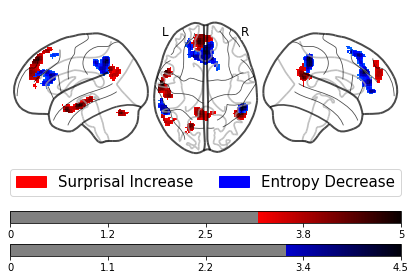

In [158]:
# setting up figure
fig = plt.figure(figsize = (7,9))

# gridspec tool
gs = fig.add_gridspec(4, 1, hspace = 0.28, wspace = 0.1, height_ratios = (2, 1, 1, 1))

# 3 axes
ax1 = fig.add_subplot(gs[0, :]) # glass brain
ax2 = fig.add_subplot(gs[1, :]) # surprisal colorbar
ax3 = fig.add_subplot(gs[2, :]) # entropy colorbar

# plotting glass brain with surprisal spm
display = plotting.plot_glass_brain(surprisal_main, display_mode = 'lzr', axes = ax1)#, colorbar = True, threshold = 3.2) 
# add overlay: entropy spm
display.add_overlay(entropy_main, cmap= plotting.cm.black_blue_r, vmin = 2)#, colorbar = True, threshold = 3.2)# vmin is really important to make the colors work properly

# plotting the colorbars with custom parameters
red_bar = ColorbarBase(
            ax2, ticks=red_ticks, norm=red_norm,
            orientation='horizontal', cmap=red_cmap_thres, boundaries=red_bounds,
            spacing='proportional', format='%.2g')

blue_bar = ColorbarBase(
            ax3, ticks=blue_ticks, norm=blue_norm,
            orientation='horizontal', cmap=blue_cmap_thres, boundaries=blue_bounds,
            spacing='proportional', format='%.2g')#, label = 't-statistics')

# configuring size and location of colorbars
ax2.set_aspect(0.03, anchor = (1,0.8))
ax3.set_aspect(0.03, anchor = (1,1.9))

# artist proxies for legend
red_patch = mpatches.Patch(color='red', label='Surprisal Increase')
blue_patch = mpatches.Patch(color='blue', label='Entropy Decrease')

# adding the legend
ax1.legend([red_patch, blue_patch],['Surprisal Increase', 'Entropy Decrease'], 
           loc='upper left', borderaxespad=0., ncol = 2, mode = 'expand', bbox_to_anchor = (0, 0, 1, 0), 
          fontsize = 15)

## Figure 2: Description

Glass brain representation of activations associated with increase in suprisal (red) or decrease in next-word entropy (p = 0.001). Color indicates activation strength (T-values).

# Figure 3: Effect of gestures on entropy-related activations

This follwing section contains all code used to set up figure 3, which contains group-level results from an activation-based GLM analysis done in SPM. Results are displayed on a glass-brain representation (3A), implemented with [nilearn](https://nilearn.github.io/modules/generated/nilearn.plotting.plot_glass_brain.html), supported by estimation statistics (3B) implemented with [DABEST](https://acclab.github.io/DABEST-python-docs/index.html), comparing VOI eigenvariates between gesture ('keywords') and non-gesture (non-keywords) conditions. The chosen contrast illustrates the effect that gestures have on the activation increase associated with low entropy during natural language processing.

## Imports and loading data

Next to matplotlib and nilearn plotting libraries, and numpy, pandas and scipy for data processing, the module dabest is loaded for the aforementioned Gardner-Altman plots. Subsequently, four volume-of-interest (VOI) eigenvariates derived with SPM12 are loaded and arranged into a datastructure that serves as an input to dabest's plotting API. 

In [21]:
from nilearn import plotting
from matplotlib import pyplot as plt
import numpy as np
import scipy.io as io #.mat compatibility
import pandas as pd
import dabest as db

In [24]:
## VOI betas for Entropy Decrease NK>K
MTL_L = io.loadmat('data\\beta_values\\VOI_MTL_L_negEnt_NK_K.mat')
mPFC = io.loadmat('data\\beta_values\\VOI_mPFC_negEnt_NK_K.mat')
AG_L = io.loadmat('data\\beta_values\\VOI_AG_L_negEnt_NK_K.mat')
IFG_L = io.loadmat('data\\beta_values\\VOI_IFG_L_negEnt_NK_K.mat')

# constructing Dataframe that fits with dabest
df = pd.DataFrame()

for region, name in [(MTL_L, 'MTL_L'), (mPFC, 'mPFC'), (AG_L, 'AG_L'), (IFG_L, 'IFG_L')]:
    
    Y = np.array(region['Y']).flatten()
    df[name + '_nonkeyE'] = Y[[i for i in range(3, len(Y), 4)]]
    df[name + '_keyE'] = Y[[i for i in range(2, len(Y), 4)]]

# dabest
all_VOI = db.load(df, idx=[(df.columns[i], df.columns[i+1]) for i in range(0, len(df.columns), 2)])

## Plotting Figure 3A

Figure 3A is a glass brain representation of regions that significantly showed activiation associated with a decrease in entropy.

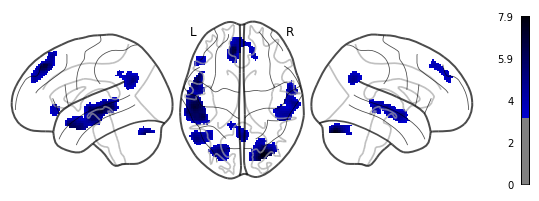

In [28]:
# load spm
entropy_dec_NK_K = 'data\\Entropy_Decrease_NK_K_p001_k89.nii'

# plotting glass brain
display = plotting.plot_glass_brain(entropy_dec_NK_K, display_mode = 'lzr', colorbar = True, threshold = 3.2, cmap= plotting.cm.black_blue_r)
display.savefig("Figure3A.png")

## Plotting Figure 3B

This is generally following the canonical API provided by the dabest module, while including customized details in terms of the color scheme and display of region names.

C:\Users\gffun\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
C:\Users\gffun\Anaconda3\lib\site-packages\IPython\core\events.py:88: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
C:\Users\gffun\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:128: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


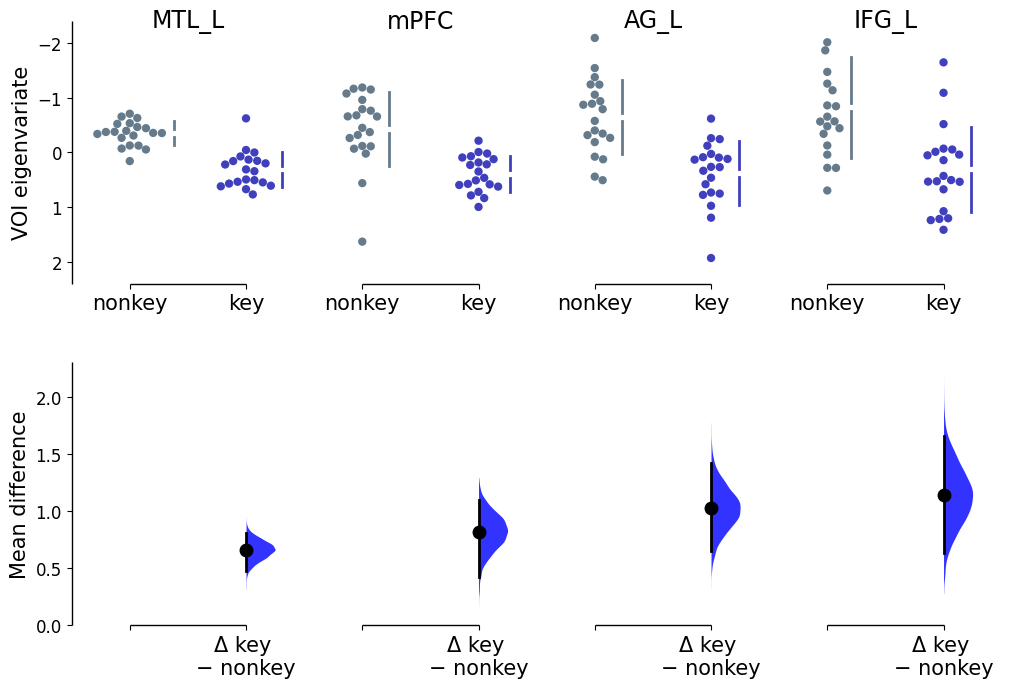

In [29]:
## plotting with dabest
# sizes for text
sz = 15
header_sz = 17

# custom color palette
my_color_palette = dict(zip(df.columns, ['#517ea0', 'blue'] * 4))

# initialize figure
f = all_VOI.mean_diff.plot(swarm_label="VOI eigenvariate", contrast_ylim = (0, 2.3), custom_palette = my_color_palette, swarm_ylim = (2.4, -2.4), fig_size = (12, 8))

# get axes
rawswarm_axes = f.axes[0]
contrast_axes = f.axes[1]

# axes labels, tick params
rawswarm_axes.set_ylabel("VOI eigenvariate",fontsize = sz)
contrast_axes.set_ylabel("Mean difference",fontsize = sz)
rawswarm_axes.set_xticklabels([ 'nonkey', 'key']*4, fontsize = sz)
contrast_axes.set_xticklabels(['','Δ key \n− nonkey']*4, fontsize = sz)
rawswarm_axes.tick_params(axis = 'y', labelsize = 12)
contrast_axes.tick_params(axis = 'y', labelsize = 12)

# 'headers' are the names of the corresponding VOIs
header_positions = [0.125*(i+1) for i in range(0,8,2)]
for position, region in zip(header_positions, ['MTL_L', 'mPFC', 'AG_L', 'IFG_L']):
    rawswarm_axes.text(position, 1, region, horizontalalignment='center', verticalalignment='center', transform=rawswarm_axes.transAxes, fontsize = header_sz) #transform brings us into axes space

## Figure 3: Description

A: glass brain representation of activation differences associated with decrease in next-word entropy between key- and nonkey words (p = 0.001). Color indicates activation strength (T-values).
B: top: subject-wise eigenvariates for key- and nonkey words in each VOI. bottom: mean difference in eigenvariates between key- and nonkey words in each VOI. MTL_L : left mid-temporal lobe; mPFC: mid-prefrontal cotex; AG_L: left angular gyrus; IFG_L : inferior frontal gyrus.